In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/PPW-A/report/Tugas-PPW

/content/drive/MyDrive/PPW-A/report/Tugas-PPW


In [3]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np

import re

import nltk
from nltk.corpus import stopwords

#stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk

from nltk.tokenize import sent_tokenize

import networkx as nx
import matplotlib.pyplot as plt

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:

# Baca file CSV
df = pd.read_csv("/content/drive/MyDrive/PPW-A/report/Tugas-PPW/data_berita_detik.csv")
df.head()

,judul,isi,tanggal,kategori
0,18 Tim yang Lolos FFWS Global Finals 2024 di B...,Jakarta - Rangkaian pertandingan di FFWS SEA 2...,"Rabu, 16 Okt 2024 19:30 WIB",Games
1,Ampun Bang Jago! Zuckerberg Klaim Pemain Handa...,"Jakarta - CEO Meta Mark Zuckerberg, cukup perc...","Rabu, 16 Okt 2024 17:50 WIB",Games
2,"20 Game Horor Terbaik Tahun 2000an, Udah Perna...",Jakarta - Game horor selalu punya daya tarikny...,"Rabu, 16 Okt 2024 14:20 WIB",Games
3,"Begini Cara Dapat Skin Zhou Yu HOK Gratis, Gam...",Jakarta - Ternyata cara dapat skin Zhou Yu Hon...,"Rabu, 16 Okt 2024 12:15 WIB",Games
4,"Gagal Juara FFWS SEA 2024 Fall, Wakil RI: Kita...","Jakarta - Tampil di depan ribuan pendukungnya,...","Selasa, 15 Okt 2024 17:36 WIB",Games


In [7]:
# mengambil satu sample berita
sample_berita = df['isi'].iloc[1]
print(sample_berita)

Jakarta - CEO Meta Mark Zuckerberg, cukup percaya diri dengan kemampuannya dalam bermain game. Dirinya mengklaim menjadi pemain paling jago di game strategi seperti Civilization. Kepercayaan dirinya tak sebatas itu saja, karena ia juga akan terkejut bila ada orang lain yang dapat mengalahkannya dalam sebuah pertandingan. Bahkan untuk membuktikannya, ia akan melakukan live streaming di Twitch dan bertanding dengan gamer lain secara online. "Saya pikir pada suatu saat saya harus melakukan streaming Twitch tentang saya bermain dengan seseorang karena saya cukup yakin bahwa saya hampir mencapai status Grandmaster. Saya akan terkejut jika ada orang di dunia yang dapat mengalahkan saya dalam hal itu," ujar Zuckerberg, dilansir detikINET dari Kotaku, Rabu (16/10/2024). Dirinya merasa paling handal, karena sudah memainkan game strategi ini selama lebih dari seribu jam. Waktu yang sudah dihabiskannya itu terungkap setelah istrinya Priscilla Chan melihat akun Steam milik Zuckerberg. "Priscilla m

In [8]:
# Membuat list untuk menyimpan hasil
result_list = []

# Pisahkan kalimat berdasarkan titik
sentences = sample_berita.split('.')  # Pisahkan kalimat berdasarkan titik
sentences = [s.strip() for s in sentences if s.strip()]  # Hilangkan spasi berlebih dan kosong

# Looping untuk menambahkan setiap kalimat ke result_list
for i, sentence in enumerate(sentences, 1):
    result_list.append({'kalimat ke n': f"Kalimat ke {i}", 'kalimat': sentence})

# Membuat DataFrame dari hasil pemisahan
result_df = pd.DataFrame(result_list)

# Tampilkan DataFrame
result_df

,kalimat ke n,kalimat
0,Kalimat ke 1,"Jakarta - CEO Meta Mark Zuckerberg, cukup perc..."
1,Kalimat ke 2,Dirinya mengklaim menjadi pemain paling jago d...
2,Kalimat ke 3,"Kepercayaan dirinya tak sebatas itu saja, kare..."
3,Kalimat ke 4,"Bahkan untuk membuktikannya, ia akan melakukan..."
4,Kalimat ke 5,"""Saya pikir pada suatu saat saya harus melakuk..."
5,Kalimat ke 6,Saya akan terkejut jika ada orang di dunia yan...
6,Kalimat ke 7,"Dirinya merasa paling handal, karena sudah mem..."
7,Kalimat ke 8,Waktu yang sudah dihabiskannya itu terungkap s...
8,Kalimat ke 9,"""Priscilla melihat akun Steam saya beberapa ha..."
9,Kalimat ke 10,Tentu saja pernyataannya itu menarik perhatian...


In [9]:
# Download stopwords untuk bahasa Indonesia
nltk.download('stopwords')
stop_words = stopwords.words('indonesian')

# Fungsi preprocessing yang disesuaikan
def remove_url(data_berita):
    url = re.compile(r'https?://\S+|www\.S+')
    return url.sub(r'', data_berita)

def remove_html(data_berita):
    html = re.compile(r'<.#?>')
    return html.sub(r'', data_berita)

def remove_emoji(data_berita):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticon
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', data_berita)

def remove_numbers(data_berita):
    data_berita = re.sub(r'\d+', '', data_berita)
    return data_berita

def remove_symbols(data_berita):
    data_berita = re.sub(r'[^a-zA-Z0-9\s]', '', data_berita)
    return data_berita

def case_folding(text):
    if isinstance(text, str):
        return text.lower()
    return text

def tokenize(text):
    return text.split()

def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    return [stemmer.stem(word) for word in text]

# Looping setiap kalimat di dataframe 'result_df'
result_df['clean'] = result_df['kalimat'].apply(remove_url)
result_df['clean'] = result_df['clean'].apply(remove_html)
result_df['clean'] = result_df['clean'].apply(remove_emoji)
result_df['clean'] = result_df['clean'].apply(remove_symbols)
result_df['clean'] = result_df['clean'].apply(remove_numbers)
result_df['clean'] = result_df['clean'].apply(case_folding)
result_df['tokenize'] = result_df['clean'].apply(tokenize)
result_df['stopword removal'] = result_df['tokenize'].apply(remove_stopwords)
result_df['stemming'] = result_df['stopword removal'].apply(stemming)

# Gabungkan kata setelah stemming
result_df['final'] = result_df['stemming'].apply(lambda x: ' '.join(x))

# Tampilkan hasil dataframe
result_df[['kalimat ke n', 'final']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,kalimat ke n,final
0,Kalimat ke 1,jakarta ceo meta mark zuckerberg percaya mampu...
1,Kalimat ke 2,klaim main jago game strategi civilization
2,Kalimat ke 3,percaya batas kejut orang kalah tanding
3,Kalimat ke 4,bukti live streaming twitch tanding gamer online
4,Kalimat ke 5,pikir streaming twitch main capai status grand...
5,Kalimat ke 6,kejut orang dunia kalah zuckerberg lansir deti...
6,Kalimat ke 7,handal main game strategi ribu jam
7,Kalimat ke 8,habis ungkap istri priscilla chan akun steam m...
8,Kalimat ke 9,priscilla akun steam main ribu jam zuckerberg
9,Kalimat ke 10,nyata tarik perhati gamer


In [10]:
# Gabungkan semua kalimat hasil stemming menjadi dokumen untuk tiap kalimat
documents = result_df['final'].tolist()

# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Terapkan TF-IDF ke dokumen (kalimat yang sudah dipreproses)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Mendapatkan nama-nama fitur (kata-kata)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Mengubah hasil TF-IDF menjadi dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Tambahkan kolom 'no' dan 'kalimat ke n' untuk identifikasi
tfidf_df.insert(0, 'kalimat ke n', result_df['kalimat ke n'])

# Tampilkan dataframe dengan skor TF-IDF
tfidf_df

,kalimat ke n,akun,banyak,batas,bilang,bukti,capai,ceo,chan,civilization,...,status,steam,strategi,streaming,tanding,tantang,tarik,twitch,ungkap,zuckerberg
0,Kalimat ke 1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.340138,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222907
1,Kalimat ke 2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.379739,...,0.000000,0.000000,0.422444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Kalimat ke 3,0.000000,0.000000,0.477303,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.417779,0.000000,0.000000,0.000000,0.000000,0.000000
3,Kalimat ke 4,0.000000,0.000000,0.000000,0.000000,0.43494,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.312363,0.380699,0.000000,0.000000,0.342214,0.000000,0.000000
4,Kalimat ke 5,0.000000,0.000000,0.000000,0.000000,0.00000,0.429393,0.000000,0.000000,0.000000,...,0.429393,0.000000,0.000000,0.308380,0.000000,0.000000,0.000000,0.337850,0.000000,0.000000
5,Kalimat ke 6,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.211823
6,Kalimat ke 7,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.434443,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Kalimat ke 8,0.321903,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.367767,0.000000,...,0.000000,0.321903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.367767,0.210958
8,Kalimat ke 9,0.422033,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.422033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.276577
9,Kalimat ke 10,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.475730,0.000000,0.000000,0.000000


In [11]:
# Menghitung cosine similarity antar kalimat berdasarkan TF-IDF
cosine_sim = cosine_similarity(tfidf_matrix)

# Membuat dataframe untuk menyimpan hasil cosine similarity
cosine_sim_df = pd.DataFrame(cosine_sim, index=result_df['kalimat ke n'], columns=result_df['kalimat ke n'])

# Tampilkan matriks cosine similarity
cosine_sim_df

kalimat ke n,Kalimat ke 1,Kalimat ke 2,Kalimat ke 3,Kalimat ke 4,Kalimat ke 5,Kalimat ke 6,Kalimat ke 7,Kalimat ke 8,Kalimat ke 9,Kalimat ke 10,Kalimat ke 11,Kalimat ke 12,Kalimat ke 13,Kalimat ke 14,Kalimat ke 15,Kalimat ke 16,Kalimat ke 17,Kalimat ke 18
kalimat ke n,,,,,,,,,,,,,,,,,,
Kalimat ke 1,1.000000,0.170269,0.114824,0.000000,0.048188,0.047217,0.175105,0.047024,0.115761,0.000000,0.148267,0.0,0.000000,0.394073,0.065811,0.000000,0.053979,0.0
Kalimat ke 2,0.170269,1.000000,0.000000,0.000000,0.059848,0.000000,0.401005,0.000000,0.067203,0.000000,0.270589,0.0,0.000000,0.255550,0.081735,0.000000,0.000000,0.0
Kalimat ke 3,0.114824,0.000000,1.000000,0.159048,0.000000,0.353265,0.000000,0.000000,0.000000,0.000000,0.182477,0.0,0.000000,0.261491,0.000000,0.000000,0.000000,0.0
Kalimat ke 4,0.000000,0.000000,0.159048,1.000000,0.211944,0.000000,0.000000,0.000000,0.000000,0.146344,0.000000,0.0,0.000000,0.000000,0.157899,0.249907,0.235380,0.0
Kalimat ke 5,0.048188,0.059848,0.000000,0.211944,1.000000,0.000000,0.061548,0.000000,0.059790,0.000000,0.076579,0.0,0.000000,0.109739,0.072719,0.246720,0.093497,0.0
Kalimat ke 6,0.047217,0.000000,0.353265,0.000000,0.000000,1.000000,0.000000,0.044686,0.058585,0.000000,0.216213,0.0,0.000000,0.154918,0.000000,0.000000,0.051295,0.0
Kalimat ke 7,0.175105,0.401005,0.000000,0.000000,0.061548,0.000000,1.000000,0.000000,0.400615,0.000000,0.088519,0.0,0.390525,0.126848,0.084057,0.000000,0.000000,0.0
Kalimat ke 8,0.047024,0.000000,0.000000,0.000000,0.000000,0.044686,0.000000,1.000000,0.465907,0.000000,0.248731,0.0,0.000000,0.053544,0.000000,0.000000,0.051086,0.0
Kalimat ke 9,0.115761,0.067203,0.000000,0.000000,0.059790,0.058585,0.400615,0.465907,1.000000,0.000000,0.183965,0.0,0.379370,0.193424,0.081656,0.000000,0.066976,0.0


In [12]:
# Tetapkan ambang batas (threshold) 0.5
threshold = 0.3

# Buat matriks adjacency: jika cosine similarity >= 0.5, maka 1; jika tidak, maka 0
adjacency_matrix = np.where(cosine_sim >= threshold, 1, 0)

# Buat dataframe untuk menampilkan matriks adjacency
adjacency_df = pd.DataFrame(adjacency_matrix, index=result_df['kalimat ke n'], columns=result_df['kalimat ke n'])

# Tampilkan matriks adjacency
adjacency_df

kalimat ke n,Kalimat ke 1,Kalimat ke 2,Kalimat ke 3,Kalimat ke 4,Kalimat ke 5,Kalimat ke 6,Kalimat ke 7,Kalimat ke 8,Kalimat ke 9,Kalimat ke 10,Kalimat ke 11,Kalimat ke 12,Kalimat ke 13,Kalimat ke 14,Kalimat ke 15,Kalimat ke 16,Kalimat ke 17,Kalimat ke 18
kalimat ke n,,,,,,,,,,,,,,,,,,
Kalimat ke 1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Kalimat ke 2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Kalimat ke 3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Kalimat ke 4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Kalimat ke 5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Kalimat ke 6,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Kalimat ke 7,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
Kalimat ke 8,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
Kalimat ke 9,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0


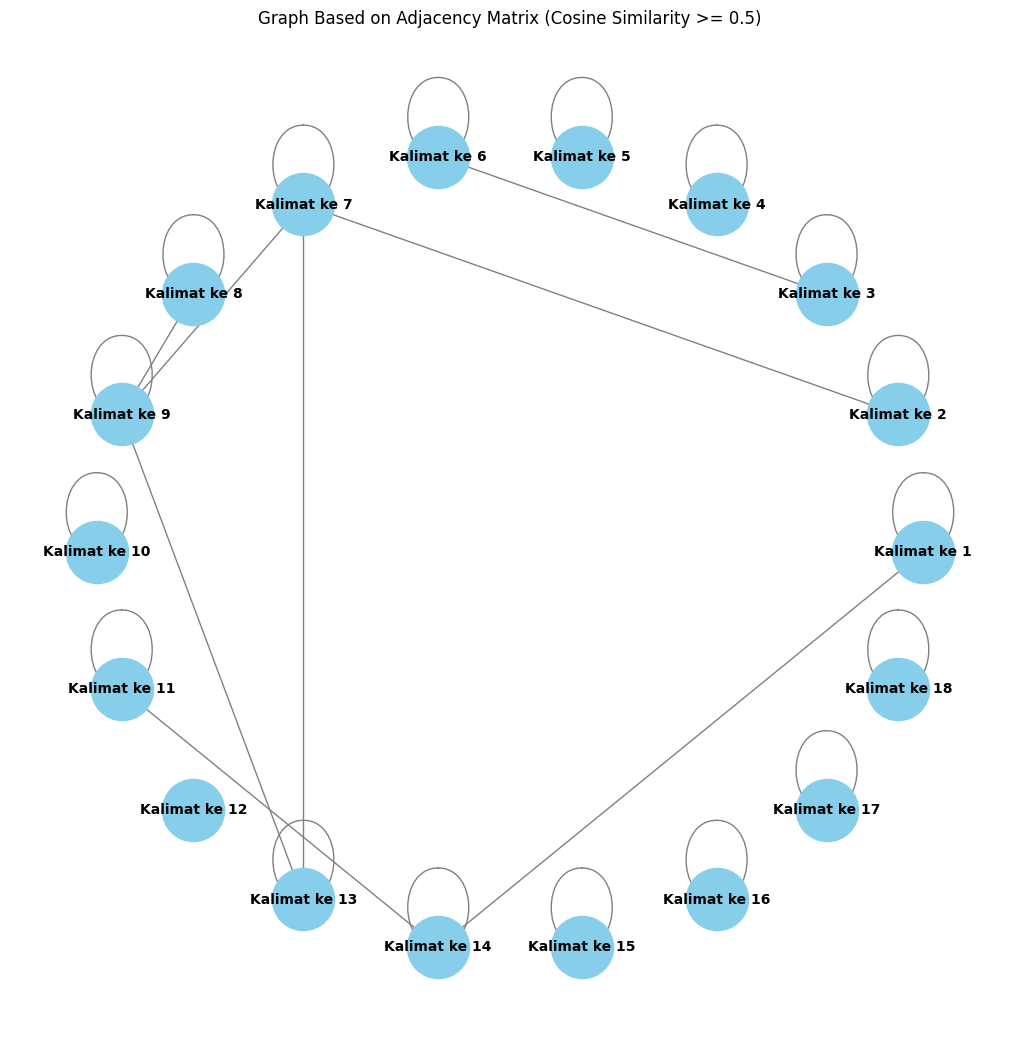

In [13]:
# Buat graf dari matriks adjacency
G = nx.from_numpy_array(adjacency_matrix)

# Atur label node agar sesuai dengan 'kalimat ke n'
mapping = {i: f"Kalimat ke {i+1}" for i in range(len(result_df))}
G = nx.relabel_nodes(G, mapping)

# Menggambar graf dengan layout circular
plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G)  # Gunakan circular layout agar rapi
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, font_color='black', edge_color='gray', linewidths=1, font_weight='bold')

# Tampilkan graf
plt.title("Graph Based on Adjacency Matrix (Cosine Similarity >= 0.5)")
plt.show()

In [14]:
# Menghitung betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Menghitung degree centrality
degree_centrality = nx.degree_centrality(G)

# Menghitung closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Buat dataframe untuk menampilkan hasil centrality
centrality_df = pd.DataFrame({
    'Kalimat': list(betweenness_centrality.keys()),
    'Betweenness Centrality': list(betweenness_centrality.values()),
    'Degree Centrality': list(degree_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values())
})

# Tampilkan dataframe centrality
centrality_df


,Kalimat,Betweenness Centrality,Degree Centrality,Closeness Centrality
0,Kalimat ke 1,0.000000,0.176471,0.078431
1,Kalimat ke 2,0.000000,0.176471,0.117647
2,Kalimat ke 3,0.000000,0.176471,0.058824
3,Kalimat ke 4,0.000000,0.117647,0.000000
4,Kalimat ke 5,0.000000,0.117647,0.000000
5,Kalimat ke 6,0.000000,0.176471,0.058824
6,Kalimat ke 7,0.022059,0.294118,0.188235
7,Kalimat ke 8,0.000000,0.176471,0.117647
8,Kalimat ke 9,0.022059,0.294118,0.188235
9,Kalimat ke 10,0.000000,0.117647,0.000000


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Masukkan isi berita: Jakarta - CEO Meta Mark Zuckerberg, cukup percaya diri dengan kemampuannya dalam bermain game. Dirinya mengklaim menjadi pemain paling jago di game strategi seperti Civilization. Kepercayaan dirinya tak sebatas itu saja, karena ia juga akan terkejut bila ada orang lain yang dapat mengalahkannya dalam sebuah pertandingan. Bahkan untuk membuktikannya, ia akan melakukan live streaming di Twitch dan bertanding dengan gamer lain secara online. "Saya pikir pada suatu saat saya harus melakukan streaming Twitch tentang saya bermain dengan seseorang karena saya cukup yakin bahwa saya hampir mencapai status Grandmaster. Saya akan terkejut jika ada orang di dunia yang dapat mengalahkan saya dalam hal itu," ujar Zuckerberg, dilansir detikINET dari Kotaku, Rabu (16/10/2024). Dirinya merasa paling handal, karena sudah memainkan game strategi ini selama lebih dari seribu jam. Waktu yang sudah dihabiskannya itu terungkap setelah istrinya Priscilla Chan melihat akun Steam milik Zuc

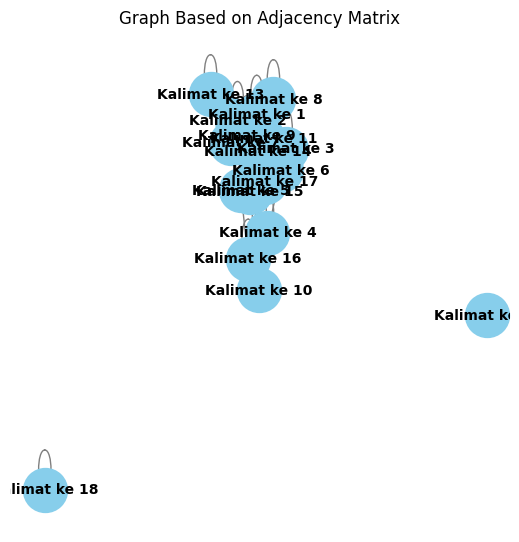


Nilai Centrality:
          Kalimat  Betweenness Centrality  Degree Centrality  \
0    Kalimat ke 1                0.016317           0.588235   
1    Kalimat ke 2                0.001050           0.529412   
2    Kalimat ke 3                0.012500           0.411765   
3    Kalimat ke 4                0.034191           0.470588   
4    Kalimat ke 5                0.053676           0.647059   
5    Kalimat ke 6                0.004359           0.411765   
6    Kalimat ke 7                0.035329           0.588235   
7    Kalimat ke 8                0.000000           0.352941   
8    Kalimat ke 9                0.092752           0.764706   
9   Kalimat ke 10                0.002451           0.294118   
10  Kalimat ke 11                0.049720           0.764706   
11  Kalimat ke 12                0.000000           0.000000   
12  Kalimat ke 13                0.000000           0.235294   
13  Kalimat ke 14                0.049720           0.764706   
14  Kalimat ke 15    

In [19]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

# Pastikan untuk mengunduh stopwords untuk bahasa Indonesia
nltk.download('stopwords')
stop_words = stopwords.words('indonesian')

# Fungsi untuk memisahkan dan memproses berita
def process_news_input(user_input):
    # Memisahkan kalimat
    result_list = []
    sentences = user_input.split('.')  # Pisahkan kalimat berdasarkan titik
    sentences = [s.strip() for s in sentences if s.strip()]  # Hilangkan spasi berlebih dan kosong
    for i, sentence in enumerate(sentences, 1):
        result_list.append({'kalimat ke n': f"Kalimat ke {i}", 'kalimat': sentence})

    result_df = pd.DataFrame(result_list)

    # Fungsi preprocessing yang disesuaikan
    def remove_url(data_berita):
        url = re.compile(r'https?://\S+|www\.S+')
        return url.sub(r'', data_berita)

    def remove_html(data_berita):
        html = re.compile(r'<.#?>')
        return html.sub(r'', data_berita)

    def remove_emoji(data_berita):
        emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"
                                   u"\U0001F300-\U0001F5FF"
                                   u"\U0001F680-\U0001F6FF"
                                   u"\U0001F1E0-\U0001F1FF""]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', data_berita)

    def remove_numbers(data_berita):
        data_berita = re.sub(r'\d+', '', data_berita)
        return data_berita

    def remove_symbols(data_berita):
        data_berita = re.sub(r'[^a-zA-Z0-9\s]', '', data_berita)
        return data_berita

    def case_folding(text):
        if isinstance(text, str):
            return text.lower()
        return text

    def tokenize(text):
        return text.split()

    def remove_stopwords(text):
        return [word for word in text if word not in stop_words]

    # Inisialisasi stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    def stemming(text):
        return [stemmer.stem(word) for word in text]

    # Looping setiap kalimat di dataframe 'result_df'
    result_df['clean'] = result_df['kalimat'].apply(remove_url)
    result_df['clean'] = result_df['clean'].apply(remove_html)
    result_df['clean'] = result_df['clean'].apply(remove_emoji)
    result_df['clean'] = result_df['clean'].apply(remove_symbols)
    result_df['clean'] = result_df['clean'].apply(remove_numbers)
    result_df['clean'] = result_df['clean'].apply(case_folding)
    result_df['tokenize'] = result_df['clean'].apply(tokenize)
    result_df['stopword removal'] = result_df['tokenize'].apply(remove_stopwords)
    result_df['stemming'] = result_df['stopword removal'].apply(stemming)

    # Gabungkan kata setelah stemming
    result_df['final'] = result_df['stemming'].apply(lambda x: ' '.join(x))

    # TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(result_df['final'])

    # Cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix)

    # Matriks adjacency
    threshold = 0.05
    adjacency_matrix = np.where(cosine_sim >= threshold, 1, 0)

    # Buat graf dari matriks adjacency
    G = nx.from_numpy_array(adjacency_matrix)

    # Atur label node
    mapping = {i: f"Kalimat ke {i+1}" for i in range(len(result_df))}
    G = nx.relabel_nodes(G, mapping)

    # Hitung centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)

    # Buat dataframe untuk centrality
    centrality_df = pd.DataFrame({
        'Kalimat': list(betweenness_centrality.keys()),
        'Betweenness Centrality': list(betweenness_centrality.values()),
        'Degree Centrality': list(degree_centrality.values()),
        'Closeness Centrality': list(closeness_centrality.values())
    })

    return result_df[['kalimat ke n', 'kalimat', 'final']], cosine_sim, adjacency_matrix, G, centrality_df

# Input dari pengguna
user_input = input("Masukkan isi berita: ")

# Proses berita dan ambil hasil
result_df, cosine_sim, adjacency_matrix, G, centrality_df = process_news_input(user_input)

# Pilih jenis centrality untuk dihitung
print("\nPilih jenis centrality yang ingin dihitung:")
print("1. Betweenness Centrality")
print("2. Degree Centrality")
print("3. Closeness Centrality")
choice = int(input("Masukkan pilihan (1/2/3): "))

# Ambil centrality sesuai pilihan
if choice == 1:
    centrality_values = centrality_df[['Kalimat', 'Betweenness Centrality']]
    centrality_name = 'Betweenness Centrality'
elif choice == 2:
    centrality_values = centrality_df[['Kalimat', 'Degree Centrality']]
    centrality_name = 'Degree Centrality'
elif choice == 3:
    centrality_values = centrality_df[['Kalimat', 'Closeness Centrality']]
    centrality_name = 'Closeness Centrality'
else:
    print("Pilihan tidak valid.")
    exit()

# Ringkasan: 3 kalimat dengan centrality tertinggi
top_sentences = centrality_values.nlargest(3, centrality_name)

# Tampilkan hasil
print("\nHasil Pemisahan Kalimat:")
print(result_df)
print("\nCosine Similarity Matrix:")
print(cosine_sim)
print("\nAdjacency Matrix:")
print(adjacency_matrix)
print("\nGraph:")
plt.figure(figsize=(5, 5))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, font_size=10, font_color='black', edge_color='gray', linewidths=1, font_weight='bold')
plt.title("Graph Based on Adjacency Matrix")
plt.show()
print("\nNilai Centrality:")
print(centrality_df)
print(f"\nRingkasan (3 Kalimat Teratas Berdasarkan {centrality_name}):")
print(top_sentences)


In [16]:
import spacy
import pandas as pd

# Memuat model bahasa Inggris spaCy
nlp = spacy.load("en_core_web_sm")

# Inisialisasi DataFrame kosong untuk menyimpan ringkasan
df_ringkasan = pd.DataFrame(columns=['Ringkasan'])

# Loop untuk setiap baris data
for i in range(100):
    # Inisialisasi teks yang akan diringkas
    teks_ringkasan = df['isi'].iloc[i]

    # Analisis teks menggunakan spaCy
    doc = nlp(teks_ringkasan)

    # Ambil setiap kalimat dari dokumen
    kalimat_utama = [kalimat.text for kalimat in doc.sents]

    # Gabungkan beberapa kalimat sesuai kebutuhan Anda
    jumlah_kalimat = 10
    data_ringkas = " ".join(kalimat_utama[:jumlah_kalimat])

    # Tambahkan ringkasan ke DataFrame
    df_ringkasan = pd.concat([df_ringkasan, pd.DataFrame({'Ringkasan': [data_ringkas]})], ignore_index=True)


In [17]:
df_ringkasan

,Ringkasan
0,Jakarta - Rangkaian pertandingan di FFWS SEA 2...
1,"Jakarta - CEO Meta Mark Zuckerberg, cukup perc..."
2,Jakarta - Game horor selalu punya daya tarikny...
3,Jakarta - Ternyata cara dapat skin Zhou Yu Hon...
4,"Jakarta - Tampil di depan ribuan pendukungnya,..."
...,...
95,Jakarta - Argentina pesta gol 6-0 melawan Boli...
96,"Jakarta - Muncul kabar, Kylian Mbappe mau pili..."
97,Qingdao - Pelatih China Branko Ivankovic memuj...
98,Jakarta - Timnas Inggris dikabarkan akan seger...
